In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import dlib
import pickle
import h5py
import cv2
import scipy

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Datasets/fer2013.csv')

In [0]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
def get_images(usage):
  df = dataset[dataset['Usage'] == usage]
  y = tf.keras.utils.to_categorical(df['emotion'])
  X = np.array([values.split() for values in df['pixels']])
  X = X.astype(np.float).reshape(len(df), 48, 48, 1)
  return (X, y)

In [0]:
usage = 'PublicTest'
test_df = dataset[dataset['Usage'] == usage]
y_test_label = test_df['emotion']
print(y_test_label.shape)

(3589,)


In [0]:
X_train, y_train = get_images('Training')
X_test, y_test =  get_images('PublicTest')
X_validate, y_validate = get_images('PrivateTest')

In [0]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

print('X_validate:', X_validate.shape)
print('y_validate:', y_validate.shape)

X_train: (28709, 48, 48, 1)
y_train: (28709, 7)
X_test: (3589, 48, 48, 1)
y_test: (3589, 7)
X_validate: (3589, 48, 48, 1)
y_validate: (3589, 7)


In [0]:
def get_label(arg):
  labels = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}
  return (labels.get(arg,"Invalid Emotion"))

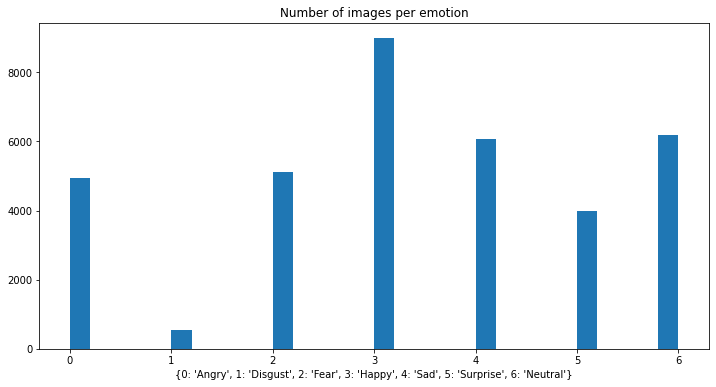

In [0]:
labels = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Number of images per emotion")
plt.xlabel(labels)
plt.show()

In [0]:
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')
val_data = X_validate.astype('float32')

train_data /= 255
test_data /= 255
val_data /= 255

In [0]:
def detect_face(frame):
  #Cascade classifier pretrained model
  cascPath = '/content/drive/My Drive/BE Project/sarvesh/haarcascades/haarcascade_frontalface_default.xml'
  faceCascade = cv2.CascadeClassifier(cascPath)
  #BGR to gray conversion
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  #Cascade multiscale classifier
  detected_faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6,
                                                minSize=(48,48),
                                                flags=cv2.CASCADE_SCALE_IMAGE)
  coord=[]
  for x, y, w, h in detected_faces:
    if w>100:
      sub_img=frame[y:y+h,x:x+w]
      coord.append([x,y,w,h])
  return gray, detected_faces, coord

In [0]:
def extract_face_features(faces, offset_coeffs=(0.075,0.05)):
  gray=faces[0]
  detected_face=faces[1]
  new_face=[]
  for det in detected_face:
    x,y,w,h=det
    #offset-coeff, np.floor takes lowest int (delete border of image)
    hor_offset=np.int(np.floor(offset_coeffs[0]*w))
    ver_offset=np.int(np.floor(offset_coeffs[1]*h))
    extracted_face=gray[y+ver_offset:y+h, x+hor_offset:x-hor_offset+w]
    #zoom
    new_extracted_face=scipy.ndimage.zoom(extracted_face,(48/extracted_face.shape[0],48/extracted_face.shape[1]))
    new_extracted_face=new_extracted_face.astype(np.float32)
    #scale
    new_extracted_face/=float(new_extracted_face.max())
    new_face.append(new_extracted_face)
  return new_face

In [0]:
from google.colab.patches import cv2_imshow

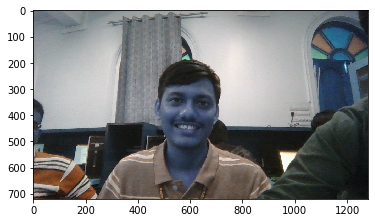

In [0]:
sample_image = '/content/drive/My Drive/Datasets/test_images/happy3.jpg'
sample_face = cv2.imread(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_face)

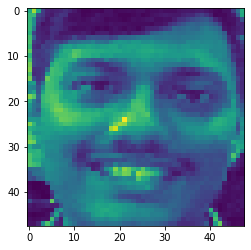

In [0]:
face = extract_face_features(detect_face(sample_face))[0]
plt.imshow(face)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2,2),strides = (1,1),activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    tf.keras.layers.Dropout(0.25),
   
    tf.keras.layers.Conv2D(64, kernel_size=(2, 2),strides = (1,1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2) ),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, kernel_size=(2, 2),strides = (1,1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(256, kernel_size=(2, 2),strides = (1,1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512, kernel_size=(2, 2),strides = (1,1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(7, activation = 'softmax')
    ])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 32)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 47, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0

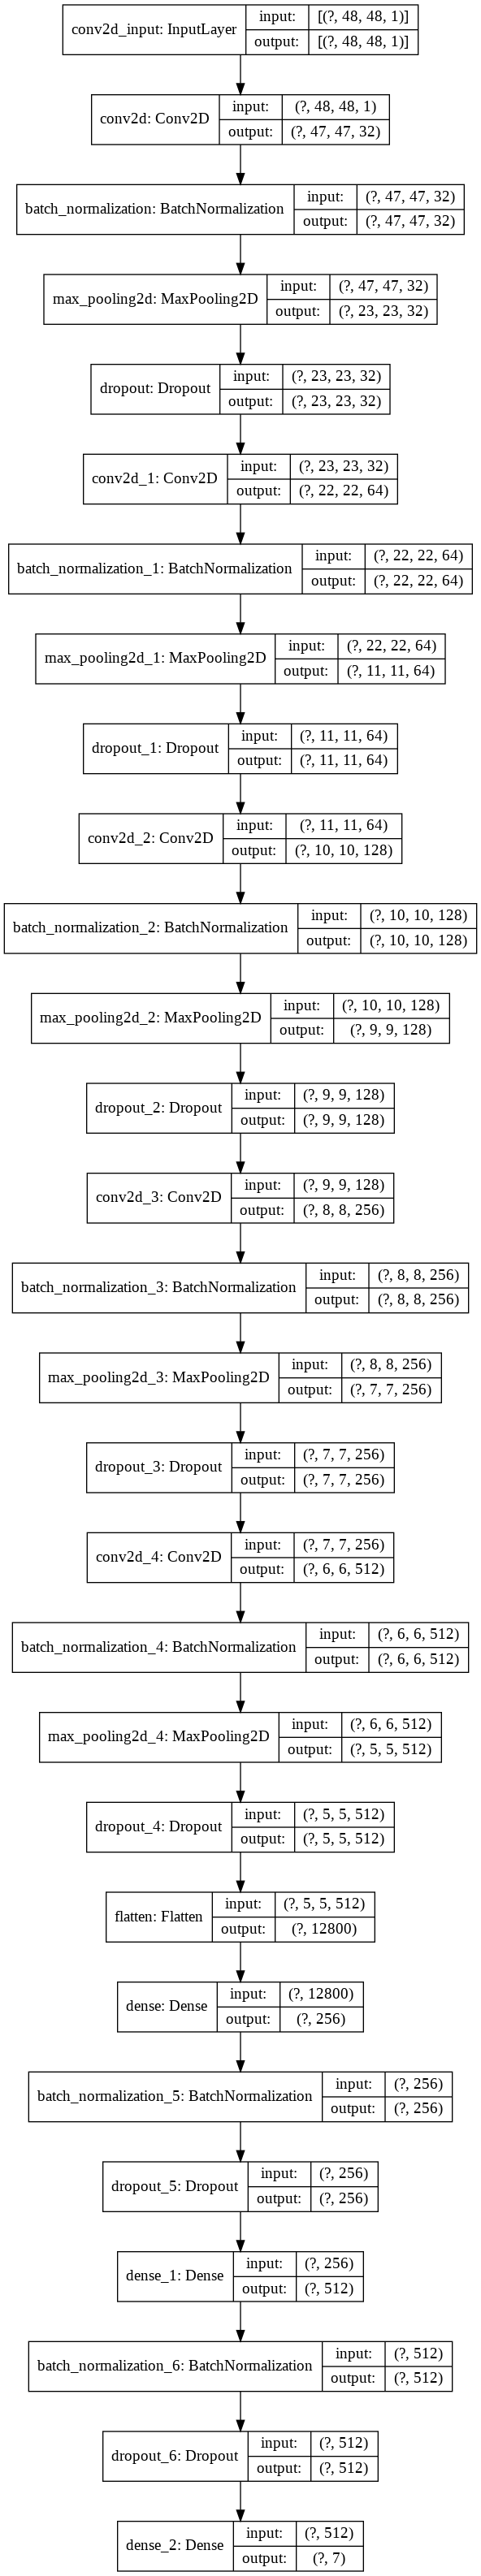

In [0]:
tf.keras.utils.plot_model(model, to_file='fer model 2.png', show_shapes=True, show_layer_names=True)

In [0]:
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     #zoom_range=0.2,
#     #rotation_range=10,
#     #width_shift_range=0.1,
#     #height_shift_range=0.1,
#     #horizontal_flip=True,
#     #vertical_flip=False
# )

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
lr_reducer_v = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

tensorboard_v = tf.keras.callbacks.TensorBoard(log_dir='./logs')

early_stopper_v = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

checkpointer_v = tf.keras.callbacks.ModelCheckpoint('model_fer_2.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
batch_size=105
epochs=100
history_fer_video_2 = model.fit(
    train_data, y_train, batch_size=batch_size,
    #train_data, y_train,

    #batch_size=batch_size,
    #steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
    epochs = epochs,
    verbose=1,
    shuffle=True,
    validation_data=(val_data, y_validate),
    callbacks=[lr_reducer_v, tensorboard_v, early_stopper_v, checkpointer_v]
)

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28560/28709 [============================>.] - ETA: 0s - loss: 1.9989 - accuracy: 0.2716
Epoch 00001: val_loss improved from inf to 3.74975, saving model to model_fervideo_2.h5
28709/28709 [==============================] - 18s 615us/sample - loss: 1.9976 - accuracy: 0.2719 - val_loss: 3.7497 - val_accuracy: 0.1744
Epoch 2/100
28665/28709 [============================>.] - ETA: 0s - loss: 1.6063 - accuracy: 0.3886
Epoch 00002: val_loss improved from 3.74975 to 2.51512, saving model to model_fervideo_2.h5
28709/28709 [==============================] - 9s 307us/sample - loss: 1.6059 - accuracy: 0.3888 - val_loss: 2.5151 - val_accuracy: 0.2828
Epoch 3/100
28665/28709 [============================>.] - ETA: 0s - loss: 1.4321 - accuracy: 0.4553
Epoch 00003: val_loss improved from 2.51512 to 1.34313, saving model to model_fervideo_2.h5
28709/28709 [==============================] - 9s 309us/sample - loss: 1.4322 - accuracy: 0.4552 

In [0]:
model.save('model_fervideo_4.h5')

Text(0.5, 1.0, 'Accuracy Curves')

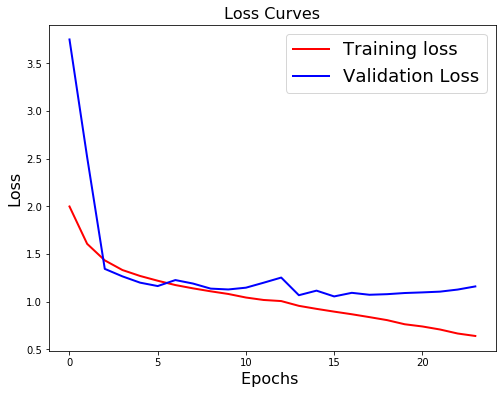

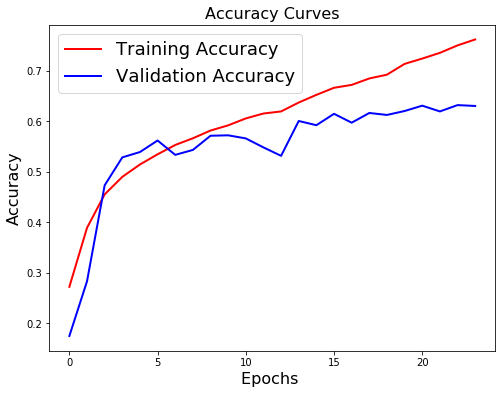

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_fer_video_2.history['loss'],'r',linewidth=2.0)
plt.plot(history_fer_video_2.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_fer_video_2.history['accuracy'],'r',linewidth=2.0)
plt.plot(history_fer_video_2.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

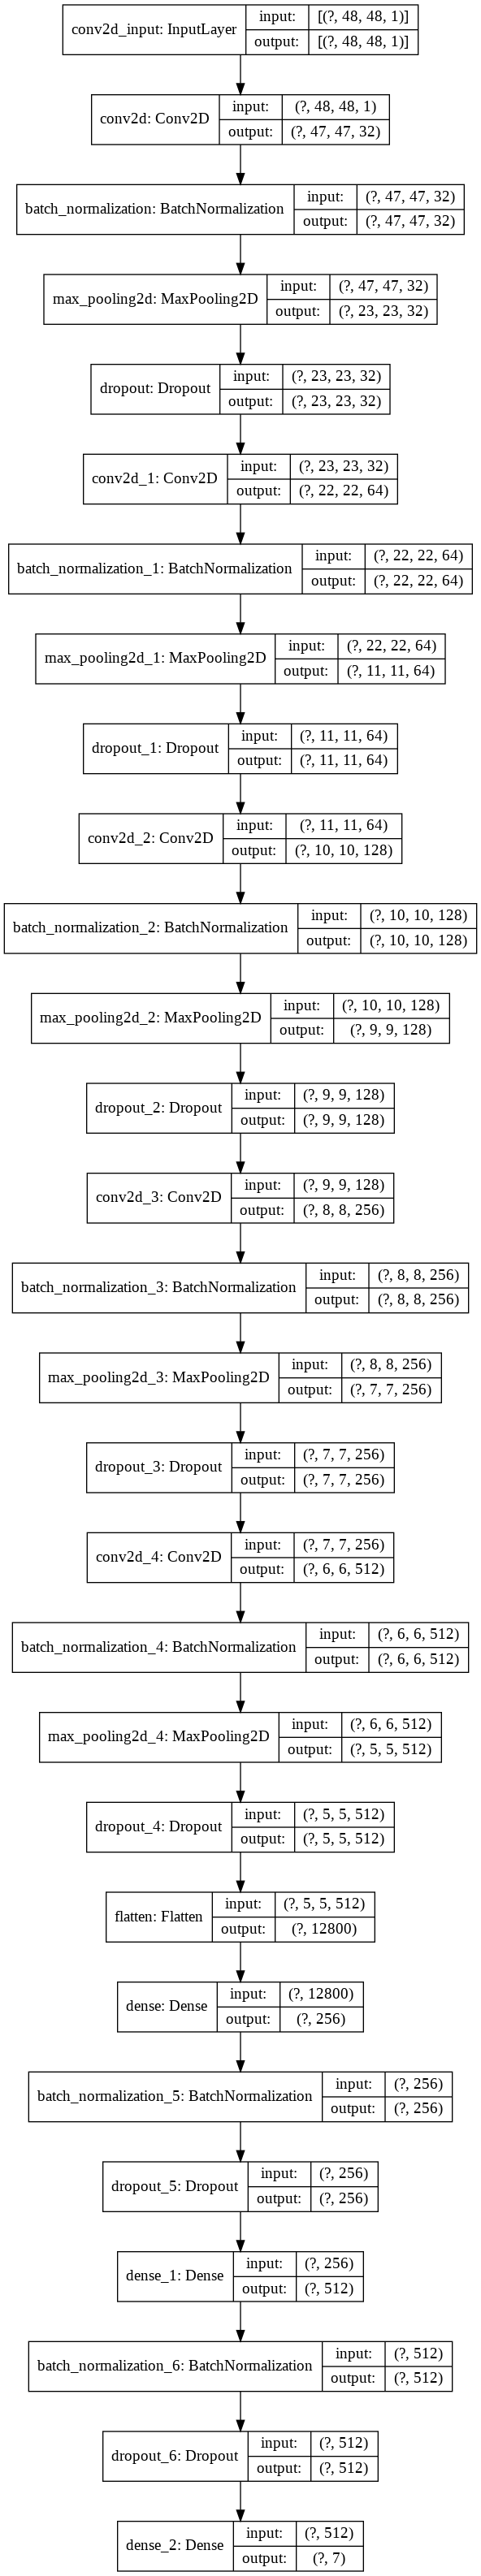

In [0]:
tf.keras.utils.plot_model(model, to_file='/content/drive/My Drive/BE PROJECT TRAINED MODELS/fer model video/model_fer_4.png', show_shapes=True, show_layer_names=True)

In [0]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict_classes(test_data)

print(y_pred.shape)

(3589,)


In [0]:
y_test_label = y_test_label.values

In [0]:
y_test_label.shape

(3589,)

In [0]:
import seaborn as sn

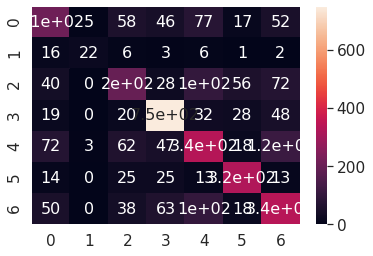

In [0]:
con = confusion_matrix(y_test_label, y_pred )

df_cm = pd.DataFrame(con, range(7), range(7))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [0]:
con

array([[212,   5,  58,  46,  77,  17,  52],
       [ 16,  22,   6,   3,   6,   1,   2],
       [ 40,   0, 198,  28, 102,  56,  72],
       [ 19,   0,  20, 748,  32,  28,  48],
       [ 72,   3,  62,  47, 336,  18, 115],
       [ 14,   0,  25,  25,  13, 325,  13],
       [ 50,   0,  38,  63, 100,  18, 338]])

In [0]:
model1 = tf.keras.models.load_model('/content/drive/My Drive/BE PROJECT TRAINED MODELS/fer model video/model_fervideo_1.h5')

In [0]:

y_pred1 = model1.predict_classes(test_data)
print(y_pred.shape)
con1 = confusion_matrix(y_test_label, y_pred1)

(3589,)


In [0]:
con1

array([[276,   8,  25,  17,  39,  15,  87],
       [ 23,  17,   0,   3,   5,   2,   6],
       [ 66,   0, 121,  13, 141,  60,  95],
       [ 18,   0,   6, 759,  13,  17,  82],
       [ 63,   0,  31,  14, 362,  14, 169],
       [ 10,   0,  24,  22,   9, 342,   8],
       [ 35,   0,  10,  36,  87,  10, 429]])

In [0]:
model2 = tf.keras.models.load_model('/content/drive/My Drive/BE PROJECT TRAINED MODELS/fer model video/model_fervideo_2.h5')

In [0]:
y_pred2 = model2.predict_classes(test_data)
print(y_pred2.shape)
con2 = confusion_matrix(y_test_label, y_pred2)

(3589,)


In [0]:
con2

array([[230,   5,  58,  40,  64,  18,  52],
       [ 15,  26,   6,   1,   4,   0,   4],
       [ 47,   4, 220,  18,  86,  47,  74],
       [ 15,   1,  13, 740,  35,  28,  63],
       [ 79,   2, 103,  45, 287,  16, 121],
       [ 14,   0,  22,  19,  11, 328,  21],
       [ 54,   0,  43,  51,  80,   7, 372]])

In [0]:
print(model.evaluate(test_data,y_test))
#print(model.evaluate(test_data,y_test))
#print(model.evaluate(test_data,y_test))

3589/3589 [==============================] - 1s 190us/sample - loss: 1.2242 - accuracy: 0.6108
[1.2241641852343503, 0.6107551]
